https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/submissions#

In [1]:
if 1:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
if 1:
    !pip install chime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 14.8 MB/s 


In [3]:
%load_ext chime
%chime 
print("Пошумим?")

Пошумим?


In [4]:
import numpy as np
import pandas as pd
import sys
import pathlib

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
import sklearn

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

In [11]:
print(tf.__version__)
print(np.__version__)
print(sklearn.__version__)

2.9.2
1.21.6
1.0.2


In [12]:
import keras
from keras.optimizers import Adam
from keras import models
keras.__version__

'2.9.0'

In [13]:
%matplotlib inline

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
if 0:
    cwd = pathlib.Path().cwd()
    sys.path.append(cwd.as_posix())
    data_folder = cwd.joinpath('data')
    model_folder = cwd.joinpath('models')

In [ ]:
if 0:
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    test_df = pd.read_csv('test_df.csv')

In [15]:
if 1:
    train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/REAL_ESTATE_PRICE_PRED/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/REAL_ESTATE_PRICE_PRED/test.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/REAL_ESTATE_PRICE_PRED/test_df.csv')

In [16]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2.20 MB
Memory usage after optimization is: 1.10 MB
Decreased by 50.0%
Memory usage of dataframe is 1.11 MB
Memory usage after optimization is: 0.55 MB
Decreased by 50.0%


In [ ]:
train.head()

,component_1,component_2,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,B_floor_cat,Ecol1_cat,MedPriceByDistrict,MedPriceByKitchenLS,MedPriceByBFF,MedPriceByEcol1,MedPriceBySocial1,MedPriceBySocial2,MedPriceByShop,Price
0,-0.568752,-0.238352,0.110048,0.00,0.047181,0.051950,0.363636,0.414634,0.252632,0.590910,...,1.0,0.0,0.000000,0.069277,0.334876,1.0,0.114130,0.053203,0.908459,137057.734375
1,-0.304161,0.212738,0.143541,0.50,0.111292,0.162295,0.454545,0.048780,0.157895,0.590910,...,0.6,0.0,0.192887,0.336552,0.323668,1.0,0.000000,0.000000,1.000000,198393.453125
2,-0.479543,-0.122593,0.224880,0.25,0.063490,0.092941,0.363636,0.317073,0.242105,0.609091,...,1.0,1.0,0.255819,0.177091,0.334876,0.0,0.000000,0.053203,0.908459,132782.671875
3,0.645006,-0.184447,0.014354,0.25,0.060727,0.087506,0.272727,0.048780,0.084211,0.563637,...,0.4,1.0,0.153944,0.211984,0.186616,0.0,0.309949,0.000000,0.908459,170229.265625
4,-0.574664,-0.244143,0.296651,0.00,0.063809,0.134922,0.000000,0.073171,0.084211,0.590910,...,0.4,0.0,0.057099,0.097312,0.186616,1.0,0.114130,0.053203,0.908459,125797.835938


In [ ]:
train.describe()

,component_1,component_2,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,B_floor_cat,Ecol1_cat,MedPriceByDistrict,MedPriceByKitchenLS,MedPriceByBFF,MedPriceByEcol1,MedPriceBySocial1,MedPriceBySocial2,MedPriceByShop,Price
count,6.700000e+03,6.700000e+03,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,-1.594202e-08,1.209885e-08,0.239999,0.227015,0.067850,0.104476,0.352554,0.183648,0.144044,0.662020,...,0.615672,0.427612,0.168825,0.192118,0.178852,0.572388,0.253606,0.175819,0.898758,213813.796875
std,5.056731e-01,4.121959e-01,0.208141,0.205067,0.034595,0.059522,0.127602,0.128326,0.063387,0.166349,...,0.263383,0.494769,0.098825,0.124025,0.173779,0.494769,0.263726,0.354554,0.149021,92488.046875
min,-5.983281e-01,-7.974033e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59877.593750
25%,-5.687477e-01,-2.498975e-01,0.095694,0.000000,0.044935,0.053424,0.272727,0.073171,0.084211,0.563637,...,0.400000,0.000000,0.129730,0.118658,0.000000,0.000000,0.000000,0.000000,0.908459,153830.011719
50%,-1.912988e-01,-1.844470e-01,0.167464,0.250000,0.061914,0.098894,0.363636,0.146341,0.157895,0.590910,...,0.600000,0.000000,0.153944,0.177091,0.186616,1.000000,0.114130,0.053203,0.908459,192034.695312
75%,5.498848e-01,2.896955e-01,0.358852,0.250000,0.082866,0.135955,0.409091,0.268293,0.168421,0.809092,...,0.800000,1.000000,0.188127,0.252172,0.323668,1.000000,0.309949,0.053203,0.908459,248570.644531
max,1.095102e+00,9.510821e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,627525.062500


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6700 entries, 0 to 6699
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   component_1                   6700 non-null   float32
 1   component_2                   6700 non-null   float32
 2   DistrictId                    6700 non-null   float32
 3   Rooms                         6700 non-null   float32
 4   Square                        6700 non-null   float32
 5   LifeSquare                    6700 non-null   float32
 6   KitchenSquare                 6700 non-null   float32
 7   Floor                         6700 non-null   float32
 8   HouseFloor                    6700 non-null   float32
 9   HouseYear                     6700 non-null   float32
 10  Ecology_1                     6700 non-null   float32
 11  Social_1                      6700 non-null   float32
 12  Social_2                      6700 non-null   float32
 13  Soc

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   component_1                   3300 non-null   float32
 1   component_2                   3300 non-null   float32
 2   DistrictId                    3300 non-null   float32
 3   Rooms                         3300 non-null   float32
 4   Square                        3300 non-null   float32
 5   LifeSquare                    3300 non-null   float32
 6   KitchenSquare                 3300 non-null   float32
 7   Floor                         3300 non-null   float32
 8   HouseFloor                    3300 non-null   float32
 9   HouseYear                     3300 non-null   float32
 10  Ecology_1                     3300 non-null   float32
 11  Social_1                      3300 non-null   float32
 12  Social_2                      3300 non-null   float32
 13  Soc

In [17]:
test.drop(columns=['MedPriceByFloorYear'], inplace=True)

# Нейронка

In [18]:
tf.random.set_seed(1)

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
train = train.astype('float32')
test = test.astype('float32')
test_df = test_df.astype('float32')

In [21]:
y_train = train['Price']
y_test = test['Price']

y_train[:5]

0    137057.734375
1    198393.453125
2    132782.671875
3    170229.265625
4    125797.835938
Name: Price, dtype: float32

In [22]:
y_train_np = np.array(y_train)

In [23]:
y_test_np = np.array(y_test)

In [24]:
X_train = train.drop(columns=['Price'])

In [25]:
X_train_np = np.array(X_train)
X_train_np[:1]

array([[-0.56875175, -0.23835216,  0.11004784,  0.        ,  0.04718135,
         0.05194995,  0.36363637,  0.41463414,  0.25263157,  0.59090996,
         0.14520702,  0.08108108,  0.06708962,  0.0212766 ,  0.28051573,
         0.        ,  0.08695652,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.00411873,  0.00693904,  0.13741812,
         0.6382609 ,  0.07127278,  0.01121207,  0.        ,  0.        ,
         1.        ,  0.40000004,  0.44444448,  1.        ,  0.        ,
         0.        ,  0.06927657,  0.33487606,  1.        ,  0.11413002,
         0.05320311,  0.9084591 ]], dtype=float32)

In [26]:
X_train_np.shape

(6700, 42)

In [27]:
X_test = test.drop(columns=['Price'])

In [28]:
X_test_np = np.array(X_test)
X_test_np[:1]

array([[-0.56874734, -0.23838675,  0.1291866 ,  0.        ,  0.0467194 ,
         0.08119309,  0.        ,  0.09756097,  0.08421053,  0.954546  ,
         0.13826814,  0.02702703,  0.02437219,  0.0070922 ,  0.09190161,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.00405773,  0.01301502,  0.19958293,
         1.0000001 ,  0.14839739,  0.0345927 ,  0.        ,  0.        ,
         0.25      ,  1.        ,  0.        ,  0.40000004,  0.        ,
         0.031335  ,  0.03232303,  0.18661642,  1.        ,  0.11413002,
         0.05320311,  0.9084591 ]], dtype=float32)

In [29]:
X_test_np[0]

array([-0.56874734, -0.23838675,  0.1291866 ,  0.        ,  0.0467194 ,
        0.08119309,  0.        ,  0.09756097,  0.08421053,  0.954546  ,
        0.13826814,  0.02702703,  0.02437219,  0.0070922 ,  0.09190161,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.00405773,  0.01301502,  0.19958293,
        1.0000001 ,  0.14839739,  0.0345927 ,  0.        ,  0.        ,
        0.25      ,  1.        ,  0.        ,  0.40000004,  0.        ,
        0.031335  ,  0.03232303,  0.18661642,  1.        ,  0.11413002,
        0.05320311,  0.9084591 ], dtype=float32)

In [30]:
X_test_np.shape

(3300, 42)

In [ ]:
+++++

In [ ]:
results = pd.DataFrame() # сводная таблица результатов
n_layers = [] # число слоев
n_nums = [] # число нейронов
act_func = [] # функция активации
opt = [] # оптимизатор
train_mse = [] # ошибка на тренировочной выборке
test_mse = [] # ошибка на тестовой выборке

Будем проверять следующие значения:
n_layers: 3, 5 и 10
n_nums: 90, 128 и 256
act_func: ReLU, sigmoid и tanh
opt: RMSProp и Adam


Параметры текущей нейронной сети: 3 слоя, 90 нейронов, функция активации relu, оптимизатор RMSprop...
210/210 - 1s - loss: 54043467776.0000 - mse: 54043467776.0000 - 863ms/epoch - 4ms/step
104/104 - 0s - loss: 54681149440.0000 - mse: 54681149440.0000 - 289ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 90 нейронов, функция активации relu, оптимизатор Adam...
210/210 - 1s - loss: 53886369792.0000 - mse: 53886369792.0000 - 788ms/epoch - 4ms/step
104/104 - 0s - loss: 54523334656.0000 - mse: 54523334656.0000 - 270ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 90 нейронов, функция активации sigmoid, оптимизатор RMSprop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


210/210 - 1s - loss: 54237687808.0000 - mse: 54237687808.0000 - 762ms/epoch - 4ms/step
104/104 - 0s - loss: 54876200960.0000 - mse: 54876200960.0000 - 289ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 90 нейронов, функция активации sigmoid, оптимизатор Adam...
210/210 - 1s - loss: 54233985024.0000 - mse: 54233985024.0000 - 810ms/epoch - 4ms/step
104/104 - 0s - loss: 54872457216.0000 - mse: 54872457216.0000 - 271ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 90 нейронов, функция активации tanh, оптимизатор RMSprop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


210/210 - 1s - loss: 54232756224.0000 - mse: 54232756224.0000 - 768ms/epoch - 4ms/step
104/104 - 0s - loss: 54871236608.0000 - mse: 54871236608.0000 - 274ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 90 нейронов, функция активации tanh, оптимизатор Adam...
210/210 - 1s - loss: 54229716992.0000 - mse: 54229716992.0000 - 1s/epoch - 6ms/step
104/104 - 0s - loss: 54868164608.0000 - mse: 54868164608.0000 - 427ms/epoch - 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



Параметры текущей нейронной сети: 3 слоя, 128 нейронов, функция активации relu, оптимизатор RMSprop...
210/210 - 1s - loss: 53961199616.0000 - mse: 53961199616.0000 - 795ms/epoch - 4ms/step
104/104 - 0s - loss: 54598504448.0000 - mse: 54598504448.0000 - 285ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 128 нейронов, функция активации relu, оптимизатор Adam...
210/210 - 1s - loss: 53714444288.0000 - mse: 53714444288.0000 - 771ms/epoch - 4ms/step
104/104 - 0s - loss: 54350680064.0000 - mse: 54350680064.0000 - 291ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 128 нейронов, функция активации sigmoid, оптимизатор RMSprop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


210/210 - 1s - loss: 54224453632.0000 - mse: 54224453632.0000 - 818ms/epoch - 4ms/step
104/104 - 0s - loss: 54862913536.0000 - mse: 54862913536.0000 - 275ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 128 нейронов, функция активации sigmoid, оптимизатор Adam...
210/210 - 1s - loss: 54218805248.0000 - mse: 54218805248.0000 - 845ms/epoch - 4ms/step
104/104 - 0s - loss: 54857236480.0000 - mse: 54857236480.0000 - 315ms/epoch - 3ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



Параметры текущей нейронной сети: 3 слоя, 128 нейронов, функция активации tanh, оптимизатор RMSprop...
210/210 - 1s - loss: 54219173888.0000 - mse: 54219173888.0000 - 773ms/epoch - 4ms/step
104/104 - 0s - loss: 54857605120.0000 - mse: 54857605120.0000 - 285ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 128 нейронов, функция активации tanh, оптимизатор Adam...
210/210 - 1s - loss: 54214086656.0000 - mse: 54214086656.0000 - 773ms/epoch - 4ms/step
104/104 - 0s - loss: 54852497408.0000 - mse: 54852497408.0000 - 273ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 256 нейронов, функция активации relu, оптимизатор RMSprop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


210/210 - 1s - loss: 53740953600.0000 - mse: 53740953600.0000 - 783ms/epoch - 4ms/step
104/104 - 0s - loss: 54377299968.0000 - mse: 54377299968.0000 - 283ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 256 нейронов, функция активации relu, оптимизатор Adam...
210/210 - 1s - loss: 53006426112.0000 - mse: 53006426112.0000 - 798ms/epoch - 4ms/step
104/104 - 0s - loss: 53639499776.0000 - mse: 53639499776.0000 - 278ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 256 нейронов, функция активации sigmoid, оптимизатор RMSprop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


210/210 - 1s - loss: 54180851712.0000 - mse: 54180851712.0000 - 786ms/epoch - 4ms/step
104/104 - 0s - loss: 54819094528.0000 - mse: 54819094528.0000 - 283ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 256 нейронов, функция активации sigmoid, оптимизатор Adam...
210/210 - 1s - loss: 54168989696.0000 - mse: 54168989696.0000 - 772ms/epoch - 4ms/step
104/104 - 0s - loss: 54807195648.0000 - mse: 54807195648.0000 - 281ms/epoch - 3ms/step

Параметры текущей нейронной сети: 3 слоя, 256 нейронов, функция активации tanh, оптимизатор RMSprop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


210/210 - 1s - loss: 54172377088.0000 - mse: 54172377088.0000 - 1s/epoch - 5ms/step
104/104 - 0s - loss: 54810595328.0000 - mse: 54810595328.0000 - 417ms/epoch - 4ms/step

Параметры текущей нейронной сети: 3 слоя, 256 нейронов, функция активации tanh, оптимизатор Adam...
210/210 - 1s - loss: 54162903040.0000 - mse: 54162903040.0000 - 854ms/epoch - 4ms/step
104/104 - 0s - loss: 54801068032.0000 - mse: 54801068032.0000 - 284ms/epoch - 3ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


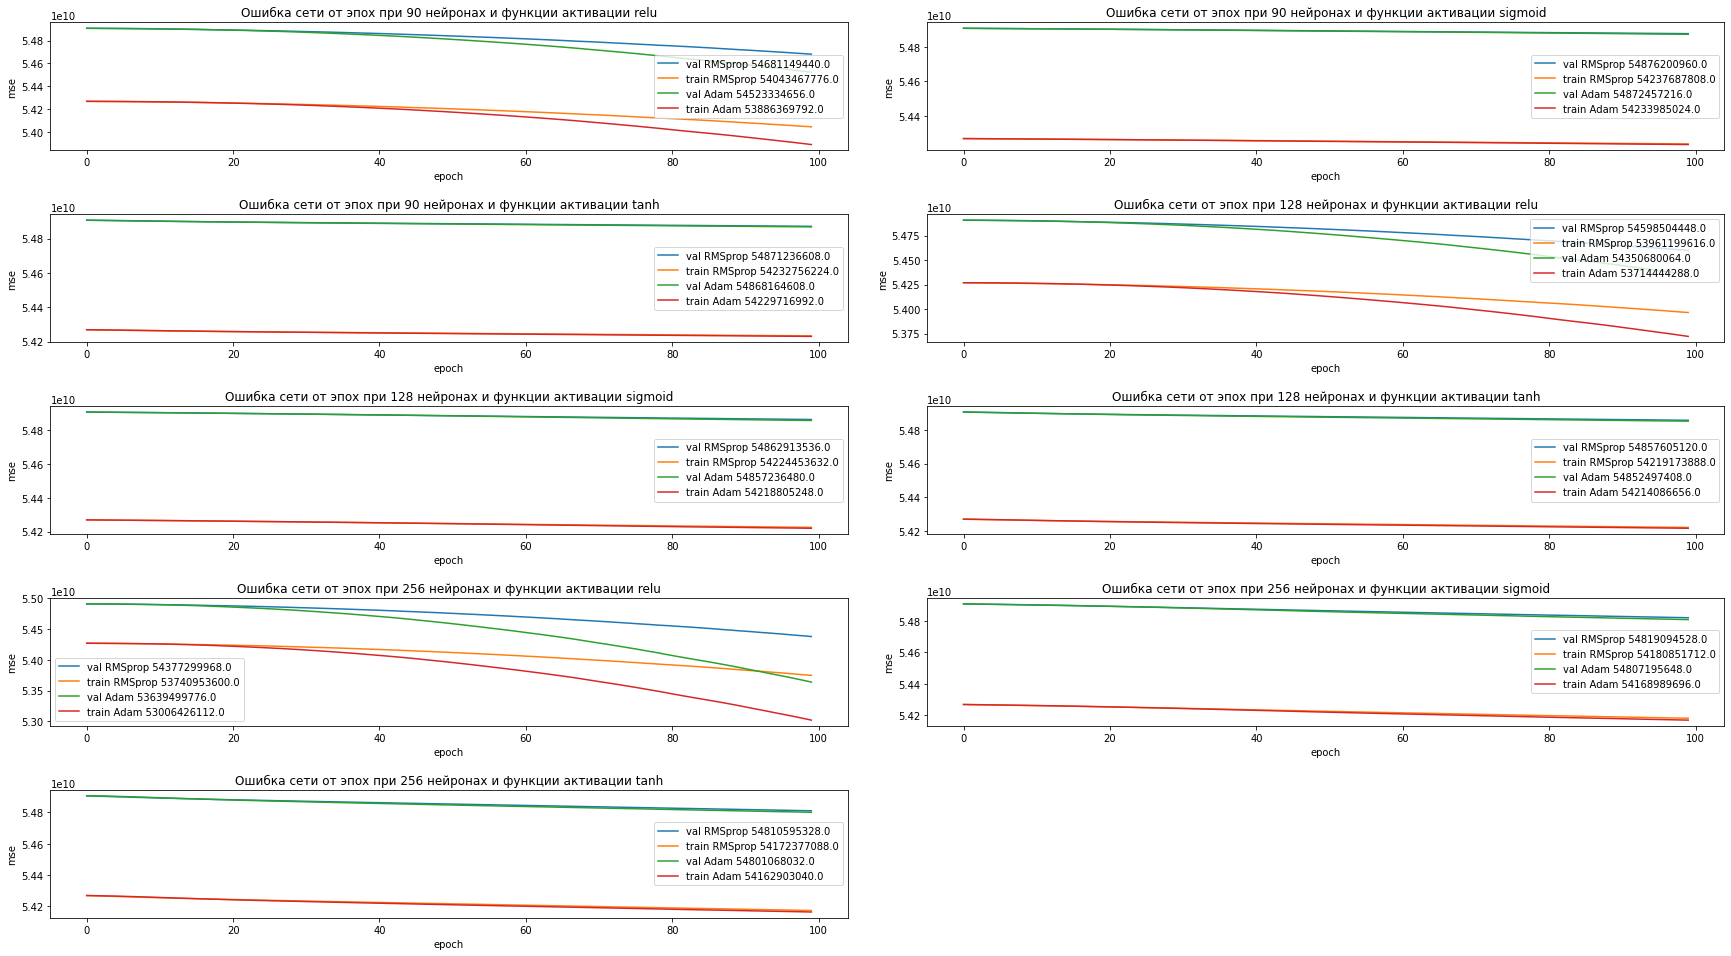

In [ ]:
# Рассмотрим 3-слойную сеть
fig = plt.figure(figsize=(30,20))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
k = 0
for n in [90, 128, 256]:
  for f in ['relu', 'sigmoid', 'tanh']:
    k += 1
    for o in ['RMSprop', 'Adam']:
      n_layers.append(3)
      n_nums.append(n)
      act_func.append(f)
      opt.append(o)
      
      print(f'\nПараметры текущей нейронной сети: 3 слоя, {n} нейронов, функция активации {f}, оптимизатор {o}...')

      inputs = Input(shape=(42,))
      x_1 = Flatten()(inputs)
      x_2 = Dense(n, activation=f)(x_1)
      outputs = Dense(1)(x_2)

      model = Model(inputs, outputs)

      model.compile(optimizer=o,
                    loss='mse',
                    metrics=['mse'])

      #model.summary()

      history = model.fit(X_train_np, y_train_np,
                    epochs=100,
                    batch_size=957,
                    validation_data=(X_test_np, y_test_np), 
                    verbose=0)

      train_loss, train_m = model.evaluate(X_train, y_train, verbose=2)
      test_loss, test_m = model.evaluate(X_test, y_test, verbose=2)
      train_mse.append(train_m)
      test_mse.append(test_m)
      
      ax = fig.add_subplot(6, 2, k)
      ax.plot(history.history['val_mse'], label=f'val {o} {round(test_m,2)}')
      ax.plot(history.history['mse'], label=f'train {o} {round(train_m,2)}')
      ax.legend()
      ax.set_xlabel('epoch')
      ax.set_ylabel('mse')
      ax.set(title = f'Ошибка сети от эпох при {n} нейронах и функции активации {f}')
plt.show()

In [ ]:
results['n_layers'] = n_layers
results['n_nums'] = n_nums
results['act_func'] = act_func
results['opt'] = opt
results['train_mse'] = train_mse
results['test_mse'] = test_mse
results['overtr_diff'] = results['test_mse'] - results['train_mse']
results.sort_values(by=['test_mse','overtr_diff'], ascending=[True, True])

,n_layers,n_nums,act_func,opt,train_mse,test_mse,overtr_diff
13,3,256,relu,Adam,5.300643e+10,5.363950e+10,633073664.0
7,3,128,relu,Adam,5.371444e+10,5.435068e+10,636235776.0
12,3,256,relu,RMSprop,5.374095e+10,5.437730e+10,636346368.0
1,3,90,relu,Adam,5.388637e+10,5.452333e+10,636964864.0
6,3,128,relu,RMSprop,5.396120e+10,5.459850e+10,637304832.0
0,3,90,relu,RMSprop,5.404347e+10,5.468115e+10,637681664.0
17,3,256,tanh,Adam,5.416290e+10,5.480107e+10,638164992.0
15,3,256,sigmoid,Adam,5.416899e+10,5.480720e+10,638205952.0
16,3,256,tanh,RMSprop,5.417238e+10,5.481060e+10,638218240.0
14,3,256,sigmoid,RMSprop,5.418085e+10,5.481909e+10,638242816.0



Параметры текущей нейронной сети: 5 слоя, 256 нейронов
210/210 - 1s - loss: 3178126848.0000 - mse: 3178126848.0000 - 1s/epoch - 7ms/step
104/104 - 0s - loss: 3296427520.0000 - mse: 3296427520.0000 - 283ms/epoch - 3ms/step
104/104 [==============================] - 0s 3ms/step
Коэффициент детерминации на тренировочной выборке, 256 нейронов: 0.63
Коэффициент детерминации на тестовой выборке, 256 нейронов: 0.62

Параметры текущей нейронной сети: 5 слоя, 512 нейронов
210/210 - 1s - loss: 3041010944.0000 - mse: 3041010944.0000 - 932ms/epoch - 4ms/step
104/104 - 0s - loss: 3187715328.0000 - mse: 3187715328.0000 - 317ms/epoch - 3ms/step
104/104 [==============================] - 0s 3ms/step
Коэффициент детерминации на тренировочной выборке, 512 нейронов: 0.64
Коэффициент детерминации на тестовой выборке, 512 нейронов: 0.64

Параметры текущей нейронной сети: 5 слоя, 1024 нейронов
210/210 - 1s - loss: 2908155392.0000 - mse: 2908155392.0000 - 1s/epoch - 6ms/step
104/104 - 0s - loss: 3089481728.

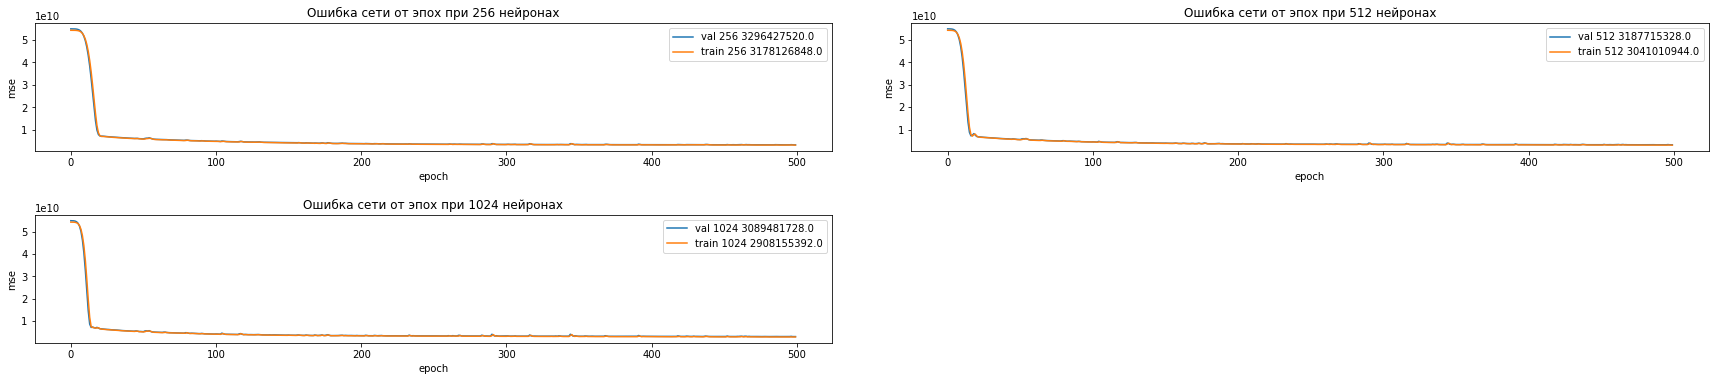

In [60]:
results = pd.DataFrame() # сводная таблица результатов
n_layers = [] # число слоев
n_nums = [] # число нейронов
train_mse = [] # ошибка на тренировочной выборке
test_mse = [] # ошибка на тестовой выборке

# Рассмотрим 5-слойную сеть
fig = plt.figure(figsize=(30,20))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
k = 0
for n in [256, 512, 1024]:
    k += 1
    n_layers.append(5)
    n_nums.append(n)
      
    print(f"\nПараметры текущей нейронной сети: 5 слоя, {n} нейронов")

    inputs = Input(shape=(42,))
    x_1 = Flatten()(inputs)
    x_2 = Dense(128, activation='relu')(x_1)
    x_3 = Dense(256, activation='relu')(x_2)
    x_4 = Dense(n, activation='relu')(x_3)
    outputs = Dense(1)(x_4)

    model = Model(inputs, outputs)

    model.compile(optimizer='Adam',
                  loss='mse',
                  metrics=['mse'])

    #model.summary()

    history = model.fit(X_train_np, y_train_np,
                  epochs=500,
                  batch_size=957,
                  validation_data=(X_test_np, y_test_np), 
                  verbose=0)

    train_loss, train_m = model.evaluate(X_train, y_train, verbose=2)
    test_loss, test_m = model.evaluate(X_test, y_test, verbose=2)
    train_mse.append(train_m)
    test_mse.append(test_m)

    y_train_pred = model.predict(X_train_np)
    y_test_pred = model.predict(X_test_np)
    r2_train = r2_score(y_train_np, y_train_pred)
    r2_test = r2_score(y_test_np, y_test_pred)
    print(f'Коэффициент детерминации на тренировочной выборке, {n} нейронов: {round(r2_train,2)}')
    print(f'Коэффициент детерминации на тестовой выборке, {n} нейронов: {round(r2_test,2)}')
      
    ax = fig.add_subplot(6, 2, k)
    ax.plot(history.history['val_mse'], label=f'val {n} {round(test_m,2)}')
    ax.plot(history.history['mse'], label=f'train {n} {round(train_m,2)}')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('mse')
    ax.set(title = f'Ошибка сети от эпох при {n} нейронах')
plt.show()

In [61]:
results['n_layers'] = n_layers
results['n_nums'] = n_nums
results['train_mse'] = train_mse
results['test_mse'] = test_mse
results['overtr_diff'] = results['test_mse'] - results['train_mse']

In [62]:
results.sort_values(by=['test_mse','overtr_diff'], ascending=[True, True])

,n_layers,n_nums,train_mse,test_mse,overtr_diff
2,5,1024,2.908155e+09,3.089482e+09,181326336.0
1,5,512,3.041011e+09,3.187715e+09,146704384.0
0,5,256,3.178127e+09,3.296428e+09,118300672.0


In [63]:
train_mse = [] # ошибка на тренировочной выборке
test_mse = [] # ошибка на тестовой выборке


Параметры текущей нейронной сети: 10 слоёв, 128 нейронов
210/210 - 0s - loss: 2337865984.0000 - mse: 2337865984.0000 - 479ms/epoch - 2ms/step
104/104 - 0s - loss: 2754422016.0000 - mse: 2754422016.0000 - 244ms/epoch - 2ms/step
104/104 [==============================] - 0s 3ms/step
Коэффициент детерминации на тренировочной выборке, 128 нейронов: 0.73
Коэффициент детерминации на тестовой выборке, 128 нейронов: 0.69

Параметры текущей нейронной сети: 10 слоёв, 256 нейронов
210/210 - 1s - loss: 2216819968.0000 - mse: 2216819968.0000 - 878ms/epoch - 4ms/step
104/104 - 0s - loss: 2714570496.0000 - mse: 2714570496.0000 - 441ms/epoch - 4ms/step
104/104 [==============================] - 0s 5ms/step
Коэффициент детерминации на тренировочной выборке, 256 нейронов: 0.74
Коэффициент детерминации на тестовой выборке, 256 нейронов: 0.69

Параметры текущей нейронной сети: 10 слоёв, 512 нейронов
210/210 - 2s - loss: 2146299520.0000 - mse: 2146299520.0000 - 2s/epoch - 8ms/step
104/104 - 1s - loss: 267

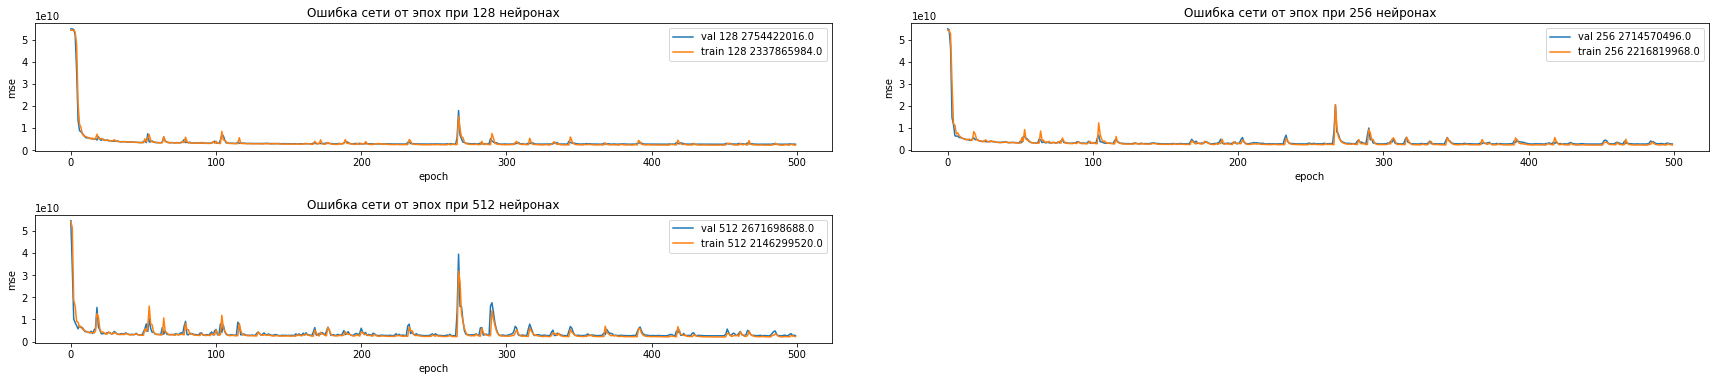

In [64]:
# Рассмотрим 10-слойную сеть
fig = plt.figure(figsize=(30,20))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
k = 0
for n in [128, 256, 512]:
    k += 1
      
    print(f'\nПараметры текущей нейронной сети: 10 слоёв, {n} нейронов')

    inputs = Input(shape=(42,))
    x_1 = Flatten()(inputs)
    x_2 = Dense(n, activation='relu')(x_1)
    x_3 = Dense(n, activation='relu')(x_2)
    x_4 = Dense(n, activation='relu')(x_3)
    x_5 = Dense(n, activation='relu')(x_4)
    x_6 = Dense(n, activation='relu')(x_5)
    x_7 = Dense(n, activation='relu')(x_6)
    x_8 = Dense(n, activation='relu')(x_7)
    x_9 = Dense(n, activation='relu')(x_8)
    outputs = Dense(1)(x_9)

    model = Model(inputs, outputs)

    model.compile(optimizer='Adam',
                  loss='mse',
                  metrics=['mse'])

    #model.summary()

    history = model.fit(X_train_np, y_train_np,
                  epochs=500,
                  batch_size=957,
                  validation_data=(X_test_np, y_test_np), 
                  verbose=0)

    train_loss, train_m = model.evaluate(X_train_np, y_train_np, verbose=2)
    test_loss, test_m = model.evaluate(X_test_np, y_test_np, verbose=2)
    train_mse.append(train_m)
    test_mse.append(test_m)

    y_train_pred = model.predict(X_train_np)
    y_test_pred = model.predict(X_test_np)
    r2_train = r2_score(y_train_np, y_train_pred)
    r2_test = r2_score(y_test_np, y_test_pred)
    print(f'Коэффициент детерминации на тренировочной выборке, {n} нейронов: {round(r2_train,2)}')
    print(f'Коэффициент детерминации на тестовой выборке, {n} нейронов: {round(r2_test,2)}')

      
    ax = fig.add_subplot(6, 2, k)
    ax.plot(history.history['val_mse'], label=f'val {n} {round(test_m,2)}')
    ax.plot(history.history['mse'], label=f'train {n} {round(train_m,2)}')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('mse')
    ax.set(title = f'Ошибка сети от эпох при {n} нейронах')
plt.show()


Попытка подобрать модель вручную

In [176]:
if 1:
    n=96
    k=0.1
    model_1 = Sequential()
    model_1.add(Dense(n, input_shape=(X_train.shape[1], ), activation='relu'))
    #model_1.add(BatchNormalization())
    model_1.add(Dense(n, activation='relu'))
    #model_1.add(Dropout(k))
    #model_1.add(BatchNormalization())
    model_1.add(Dense(n, activation='relu'))
    #model_1.add(Dropout(k))
    #model_1.add(BatchNormalization())
    model_1.add(Dense(n, activation='relu'))
    #model_1.add(Dropout(k))
    #model_1.add(BatchNormalization())
    model_1.add(Dense(n, activation='relu'))
    #model_1.add(Dropout(k))
    #model_1.add(BatchNormalization())
    model_1.add(Dense(n/2, activation='relu'))
    #model_1.add(Dropout(k))
    model_1.add(Dense(n/4, activation='relu'))
    #model_1.add(Dropout(k))
    #model_1.add(BatchNormalization())
    model_1.add(Dense(n/8, activation='relu'))
    #model_1.add(Dropout(k))
    #model_1.add(BatchNormalization())
    #model_1.add(Dense(n/32, activation='relu'))
    #model_1.add(BatchNormalization())
    #model_1.add(Dense(n, activation='relu'))
    #model_1.add(BatchNormalization())
    #model_1.add(Dense(n, activation='relu'))
    #model_1.add(BatchNormalization())
    #model_1.add(Dense(n, activation='relu'))
    #model_1.add(BatchNormalization())
    model_1.add(Dense(1))

    model_1.summary()



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           (None, 96)                4128      
                                                                 
 dense_167 (Dense)           (None, 96)                9312      
                                                                 
 dense_168 (Dense)           (None, 96)                9312      
                                                                 
 dense_169 (Dense)           (None, 96)                9312      
                                                                 
 dense_170 (Dense)           (None, 96)                9312      
                                                                 
 dense_171 (Dense)           (None, 48)                4656      
                                                                 
 dense_172 (Dense)           (None, 24)              

In [177]:
if 1:
    model_1.compile(optimizer=tf.keras.optimizers.Adam(), #(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])


In [143]:
from tensorflow.keras import callbacks

In [44]:
if 1:
    model_checkpoint = callbacks.ModelCheckpoint(filepath='model_best',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   save_freq='epoch')

In [ ]:
if 0:
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.001,
                                        cooldown=0,
                                        min_lr=1e-10)

In [36]:
if 0:
    early_stop = callbacks.EarlyStopping(monitor='mse',
                                     min_delta=0.001,
                                     patience=20,
                                     verbose=1,
                                     mode='auto',
                                     baseline=None,
                                     restore_best_weights=False)

In [178]:
history = model_1.fit(X_train_np, y_train_np,
                    epochs=900,
                    batch_size=957,
                    verbose=1,
                    validation_data=(X_test_np, y_test_np),
                    callbacks=[model_checkpoint]
                    )

Epoch 1/900
1/8 [==>...........................] - ETA: 4s - loss: 54072827904.0000 - mse: 54072827904.0000
Epoch 1: val_loss did not improve from 2502818560.00000
8/8 [==============================] - 1s 29ms/step - loss: 54269009920.0000 - mse: 54269009920.0000 - val_loss: 54907428864.0000 - val_mse: 54907428864.0000
Epoch 2/900
1/8 [==>...........................] - ETA: 0s - loss: 55337889792.0000 - mse: 55337889792.0000
Epoch 2: val_loss did not improve from 2502818560.00000
8/8 [==============================] - 0s 9ms/step - loss: 54268358656.0000 - mse: 54268358656.0000 - val_loss: 54905671680.0000 - val_mse: 54905671680.0000
Epoch 3/900
1/8 [==>...........................] - ETA: 0s - loss: 55158272000.0000 - mse: 55158272000.0000
Epoch 3: val_loss did not improve from 2502818560.00000
8/8 [==============================] - 0s 9ms/step - loss: 54264766464.0000 - mse: 54264766464.0000 - val_loss: 54896005120.0000 - val_mse: 54896005120.0000
Epoch 4/900
1/8 [==>................

In [179]:
y_train_pred = model_1.predict(X_train_np)
y_test_pred = model_1.predict(X_test_np)

104/104 [==============================] - 0s 2ms/step


In [180]:
r2_train = r2_score(y_train_np, y_train_pred)
r2_test = r2_score(y_test_np, y_test_pred)

print(f'Коэффициент детерминации на тренировочной выборке: {round(r2_train,2)}')
print(f'Коэффициент детерминации на тестовой выборке: {round(r2_test,2)}')

Коэффициент детерминации на тренировочной выборке: 0.73
Коэффициент детерминации на тестовой выборке: 0.69


In [181]:
best_model=models.load_model("/content/model_best")

OSError: ignored

In [ ]:
y_train_pred = best_model.predict(X_train_np)
y_test_pred = best_model.predict(X_test_np)

In [ ]:
r2_train = r2_score(y_train_np, y_train_pred)
r2_test = r2_score(y_test_np, y_test_pred)

print(f'Коэффициент детерминации на тренировочной выборке: {round(r2_train,2)}')
print(f'Коэффициент детерминации на тестовой выборке: {round(r2_test,2)}')

In [182]:
model_path = "my_model_1"

In [183]:
model_1.save(model_path)